<a href="https://colab.research.google.com/github/pavlo-da/portfolio-project-1-python/blob/main/Portfolio_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth, drive
auth.authenticate_user()
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, f_oneway, ttest_ind, mannwhitneyu, chi2_contingency
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
# Initialize BigQuery client
client = bigquery.Client(project="data-analytics-mate")

In [ ]:
# SQL query to join tables and select required fields
query = """
SELECT
  sess.date AS order_date,
  ord.ga_session_id,
  sess_par.continent,
  sess_par.country,
  sess_par.device,
  sess_par.browser,
  sess_par.mobile_model_name AS mobile_model,
  sess_par.operating_system,
  sess_par.language,
  sess_par.medium AS traffic_source,
  sess_par.channel AS traffic_channel,
  acc.id AS account_id,
  acc.is_verified,
  acc.is_unsubscribed,
  prod.category,
  prod.name AS product_name,
  prod.price,
  prod.short_description
FROM `data-analytics-mate.DA.order` AS ord
JOIN `data-analytics-mate.DA.session` AS sess
  ON ord.ga_session_id = sess.ga_session_id
JOIN `data-analytics-mate.DA.session_params` AS sess_par
  ON ord.ga_session_id = sess_par.ga_session_id
LEFT JOIN `data-analytics-mate.DA.account_session` AS acc_sess
  ON ord.ga_session_id = acc_sess.ga_session_id
LEFT JOIN `data-analytics-mate.DA.account` AS acc
  ON acc_sess.account_id = acc.id
JOIN `data-analytics-mate.DA.product` AS prod
  ON ord.item_id = prod.item_id
"""


In [ ]:
# Execute query and load into a DataFrame
df = client.query(query).to_dataframe()

df.head()

,order_date,ga_session_id,continent,country,device,browser,mobile_model,operating_system,language,traffic_source,traffic_channel,account_id,is_verified,is_unsubscribed,category,product_name,price,short_description
0,2020-12-24,5726438444,(not set),(not set),desktop,Chrome,Chrome,Web,None,referral,Paid Search,<NA>,<NA>,<NA>,Cabinets & cupboards,LIXHULT,356.0,"Wall-mounted cabinet combination, 50x25x50 cm"
1,2020-12-13,5614986004,(not set),(not set),desktop,<Other>,<Other>,Web,en-ca,organic,Organic Search,<NA>,<NA>,<NA>,Tables & desks,BEKANT,1325.0,"Desk, 140x60 cm"
2,2020-11-05,8542454082,(not set),(not set),desktop,Chrome,Safari,Web,en-us,(data deleted),Undefined,<NA>,<NA>,<NA>,Chairs,ANTILOP,20.0,Cover
3,2020-12-16,1717992506,(not set),(not set),mobile,Safari,iPhone,Web,en-us,(data deleted),Undefined,<NA>,<NA>,<NA>,Beds,SUNDVIK,849.0,"Ext bed frame with slatted bed base, 80x200 cm"
4,2021-01-16,8416141289,(not set),(not set),desktop,Chrome,Safari,Web,en-gb,(none),Direct,<NA>,<NA>,<NA>,Bookcases & shelving units,ALGOT,130.0,"Wall upright/drying rack, 66x41x197 cm"


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33538 entries, 0 to 33537
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   order_date         33538 non-null  datetime64[ns]
 1   ga_session_id      33538 non-null  object        
 2   continent          33538 non-null  object        
 3   country            33538 non-null  object        
 4   device             33538 non-null  object        
 5   browser            33538 non-null  object        
 6   mobile_model       33538 non-null  object        
 7   operating_system   33538 non-null  object        
 8   language           22531 non-null  object        
 9   traffic_source     33538 non-null  object        
 10  traffic_channel    33538 non-null  object        
 11  account_id         2781 non-null   Int64         
 12  is_verified        2781 non-null   Int64         
 13  is_unsubscribed    2781 non-null   Int64         
 14  catego

In [ ]:
# Convert 'ga_session_id' to string type
df['ga_session_id'] = df['ga_session_id'].astype(str)

# Convert 'order_date' to datetime
df['order_date'] = pd.to_datetime(df['order_date'])

In [ ]:
total_columns = df.shape[1]

numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
num_numeric = len(numeric_cols)

categorical_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
num_categorical = len(categorical_cols)

datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns.tolist()
num_datetime = len(datetime_cols)

unique_sessions = df['ga_session_id'].nunique()

period_start = df['order_date'].min()
period_end = df['order_date'].max()

missing_counts = df.isnull().sum().sort_values(ascending=False)
total_missing = missing_counts.sum()
columns_with_missing = missing_counts[missing_counts > 0]

registered_ratio = df['account_id'].count() / len(df)

negative_prices = df[df['price'] <= 0]

print(f"Total columns: {total_columns}")
print(f"\nNumeric columns ({num_numeric}): {numeric_cols}")
print(f"\nCategorical columns ({num_categorical}): {categorical_cols}")
print(f"\nDatetime columns ({num_datetime}): {datetime_cols}")
print(f"\nUnique sessions: {unique_sessions}")
print(f"\nTime period: from {period_start.date()} to {period_end.date()}")
print(f"\nTotal missing values: {total_missing}")
print("\nMissing values by column:")
print(columns_with_missing)
print(f"\nSessions with registered users: {registered_ratio:.1%}")
print(f"\nRecords with invalid prices: {len(negative_prices)}")

Total columns: 18

Numeric columns (4): ['account_id', 'is_verified', 'is_unsubscribed', 'price']

Categorical columns (13): ['ga_session_id', 'continent', 'country', 'device', 'browser', 'mobile_model', 'operating_system', 'language', 'traffic_source', 'traffic_channel', 'category', 'product_name', 'short_description']

Datetime columns (1): ['order_date']

Unique sessions: 33538

Time period: from 2020-11-01 to 2021-01-27

Total missing values: 103278

Missing values by column:
is_unsubscribed    30757
is_verified        30757
account_id         30757
language           11007
dtype: int64

Sessions with registered users: 8.3%

Records with invalid prices: 0


In [ ]:
# Category normalization check
normalized_categories = df['category'].str.lower()
unique_normalized_count = normalized_categories.nunique()

print(f"Original unique categories: {df['category'].nunique()}")
print(f"Unique categories after case normalization: {unique_normalized_count}")
print("Normalized categories:")
print(normalized_categories.unique())

Original unique categories: 14
Unique categories after case normalization: 14
Normalized categories:
['cabinets & cupboards' 'tables & desks' 'chairs' 'beds'
 'bookcases & shelving units' 'nursery furniture' 'outdoor furniture'
 'sofas & armchairs' 'café furniture' "children's furniture"
 'chests of drawers & drawer units' 'bar furniture'
 'sideboards, buffets & console tables' 'room dividers']


In [ ]:
# Additional transformations
df['user_type'] = np.where(df['account_id'].isna(), 'guest', 'registered')
df['language'] = df['language'].fillna('unknown')

In [ ]:
# Top-3 continents by total sales (sum of price)
continent_sales = df.groupby('continent')['price'].sum().sort_values(ascending=False)
print("Top 3 continents by total sales:")
print(continent_sales.head(3), "\n")

# Top-3 continents by number of orders
continent_orders = df['continent'].value_counts()
print("Top 3 continents by number of orders:")
print(continent_orders.head(3), "\n")

# Top-5 countries by total sales
country_sales = df.groupby('country')['price'].sum().sort_values(ascending=False)
print("Top 5 countries by total sales:")
print(country_sales.head(5), "\n")

# Top-5 countries by number of orders
country_orders = df['country'].value_counts()
print("Top 5 countries by number of orders:")
print(country_orders.head(5), "\n")

Top 3 continents by total sales:
continent
Americas    17665280.0
Asia         7601298.3
Europe       5934624.2
Name: price, dtype: float64 

Top 3 continents by number of orders:
continent
Americas    18553
Asia         7950
Europe       6261
Name: count, dtype: int64 

Top 5 countries by total sales:
country
United States     13943553.9
India              2809762.0
Canada             2437921.0
United Kingdom      938317.9
France              710692.8
Name: price, dtype: float64 

Top 5 countries by number of orders:
country
United States     14673
India              3029
Canada             2560
United Kingdom     1029
France              678
Name: count, dtype: int64 



In [ ]:
# Top-10 categories by total sales
cat_sales = df.groupby('category')['price'].sum().sort_values(ascending=False)

print("Top 10 categories by total sales:")
print(cat_sales.head(10))

Top 10 categories by total sales:
category
Sofas & armchairs                   8388254.5
Chairs                              6147748.8
Beds                                4919725.0
Bookcases & shelving units          3640818.1
Cabinets & cupboards                2336499.5
Outdoor furniture                   2142222.2
Tables & desks                      1790307.5
Chests of drawers & drawer units     906562.5
Bar furniture                        735503.0
Children's furniture                 467697.0
Name: price, dtype: float64


In [ ]:
# Identify country with highest sales
top_country = country_sales.idxmax()

# Top-10 categories by total sales in that country
cat_sales_top_country = df[df['country']==top_country].groupby('category')['price'].sum().sort_values(ascending=False)

print(f"Top 10 categories by sales in {top_country}:")
print(cat_sales_top_country.head(10))

Top 10 categories by sales in United States:
category
Sofas & armchairs                   3707144.5
Chairs                              2619773.8
Beds                                2213058.0
Bookcases & shelving units          1567606.9
Cabinets & cupboards                 994545.5
Outdoor furniture                    929245.2
Tables & desks                       777865.0
Chests of drawers & drawer units     382388.0
Bar furniture                        330805.0
Children's furniture                 207575.0
Name: price, dtype: float64


In [ ]:
# Sales breakdown by device type and model (% of total sales)
total_sales = df['price'].sum()
device_sales = df.groupby('device')['price'].sum() / total_sales * 100
model_sales = df.groupby('mobile_model')['price'].sum() / total_sales * 100

print("Sales by device type (%):")
print(device_sales.sort_values(ascending=False), "\n")
print("Sales by mobile model (%):")
print(model_sales.sort_values(ascending=False).head(10))

Sales by device type (%):
device
desktop    59.002245
mobile     38.734924
tablet      2.262831
Name: price, dtype: float64 

Sales by mobile model (%):
mobile_model
Chrome        27.835602
<Other>       20.440966
Safari        20.302504
iPhone        20.082667
ChromeBook     5.725241
Edge           2.180746
iPad           1.403910
Firefox        1.316998
Pixel 4 XL     0.369976
Pixel 3        0.341390
Name: price, dtype: float64


In [ ]:
# Sales by traffic source (% of total sales)
traffic_sales = df.groupby('traffic_source')['price'].sum() / total_sales * 100

print("Sales by traffic source (%):")
print(traffic_sales.sort_values(ascending=False))

Sales by traffic source (%):
traffic_source
organic           34.202840
(none)            23.442345
referral          17.646386
<Other>           14.047882
(data deleted)     6.386645
cpc                4.273902
Name: price, dtype: float64


In [ ]:
# Verification and unsub info for registered users
total_registered = df['account_id'].nunique()
verified_count = df[df['is_verified']==True]['account_id'].nunique()
unsubscribed_count = df[df['is_unsubscribed']==True]['account_id'].nunique()

print(f"% of registered users who verified email: {verified_count/total_registered*100:.2f}%")
print(f"% of registered users who unsubscribed: {unsubscribed_count/total_registered*100:.2f}%")

% of registered users who verified email: 71.52%
% of registered users who unsubscribed: 16.07%


In [ ]:
# Sales comparison: unsubscribed vs still subscribed
sales_unsub = df[df['is_unsubscribed']==True]['price'].sum()
sales_sub = df[df['is_unsubscribed']==False]['price'].sum()

print("Sales unsubscribe vs subscribed:")
print(f"Unsubscribed users: {sales_unsub:.0f}, Subscribed users: {sales_sub:.0f}")

Sales unsubscribe vs subscribed:
Unsubscribed users: 431722, Subscribed users: 2150797


In [ ]:
# Countries with most registered users
reg_users_country = df.dropna(subset=['account_id']).groupby('country')['account_id'].nunique().sort_values(ascending=False)

print("Top countries by number of registered users:")
print(reg_users_country.head(5))

Top countries by number of registered users:
country
United States     1207
India              246
Canada             207
United Kingdom      88
France              56
Name: account_id, dtype: int64


In [ ]:
# Average Order Value
aov = df.groupby('ga_session_id')['price'].sum().mean()

print(f"AOV: {aov:.2f}")

AOV: 953.30


Then I created four visualizations:

- Bar chart of top 10 product categories by total sales

- Pie chart of sales distribution across device types

- Bar chart of sales by traffic source

- Line chart of daily sales over time

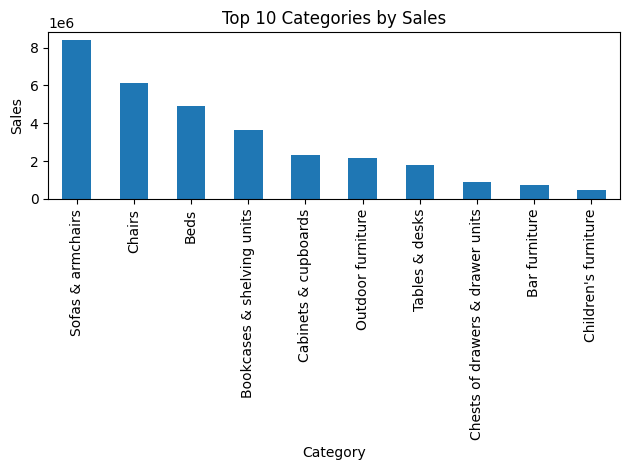

In [ ]:
plt.figure()
cat_sales.head(10).plot(kind='bar')
plt.title('Top 10 Categories by Sales')
plt.xlabel('Category')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

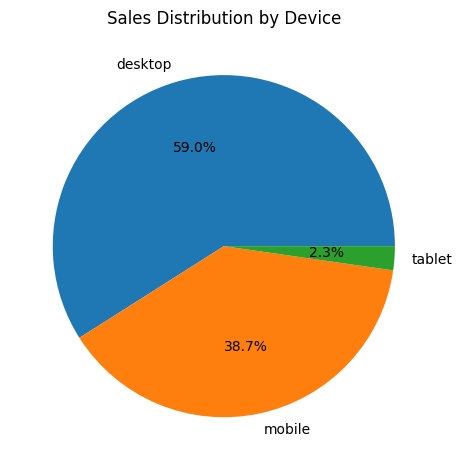

In [ ]:
plt.figure()
device_sales.plot(kind='pie', autopct='%1.1f%%')
plt.title('Sales Distribution by Device')
plt.ylabel('')
plt.tight_layout()
plt.show()

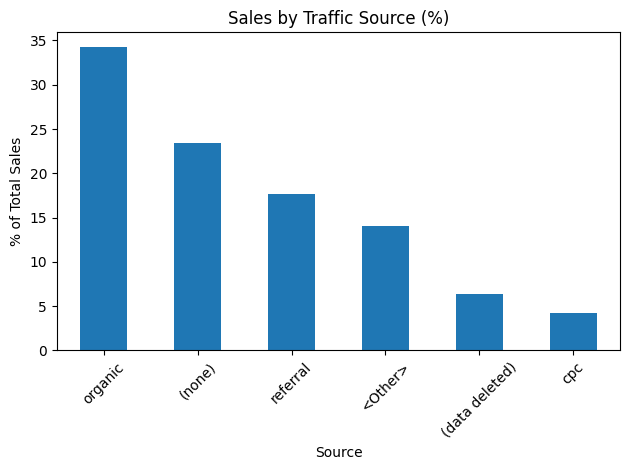

In [ ]:
plt.figure()
traffic_sales.sort_values(ascending=False).plot(kind='bar')
plt.title('Sales by Traffic Source (%)')
plt.xlabel('Source')
plt.xticks(rotation=45)
plt.ylabel('% of Total Sales')
plt.tight_layout()
plt.show()

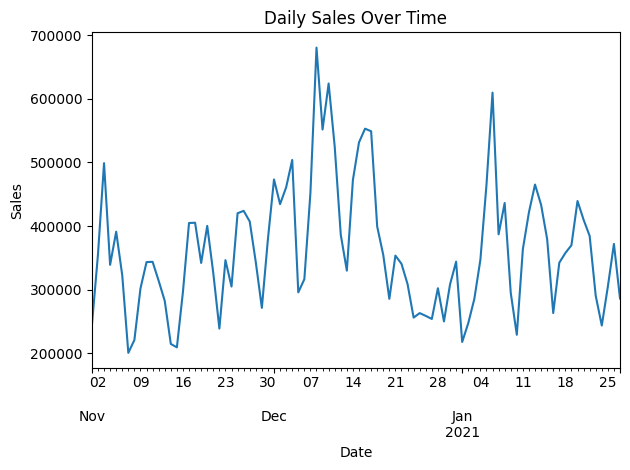

In [ ]:
plt.figure()
df.groupby('order_date')['price'].sum().plot()
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

Sales seasonality is evident with peaks in December (holiday purchases) and January (post-holiday sales), followed by a mid-period dip.

###6

In [ ]:
df_clean = df.dropna(subset=['traffic_channel', 'device'])

In [ ]:
# Pivot: number of sessions by traffic channel and device type
pivot_sessions = pd.pivot_table(
    df_clean[['ga_session_id','traffic_channel','device']],
    index='traffic_channel',
    columns='device',
    values='ga_session_id',
    aggfunc=lambda x: x.nunique()
).fillna(0).astype(int)

print("Sessions by Traffic Channel and Device Type:")
print(pivot_sessions)

Sessions by Traffic Channel and Device Type:
device           desktop  mobile  tablet
traffic_channel                         
Direct              4655    2985     160
Organic Search      7011    4655     255
Paid Search         5261    3574     207
Social Search       1594    1065      57
Undefined           1181     834      44


In [ ]:
# Pivot: total sales for top-10 categories across top-5 countries
# Identify top categories and countries
top_categories = df.groupby('category')['price'].sum().nlargest(10).index
top_countries = df.groupby('country')['price'].sum().nlargest(5).index
subset = df[df['category'].isin(top_categories) & df['country'].isin(top_countries)]

pivot_sales = pd.pivot_table(
    subset,
    index='category',
    columns='country',
    values='price',
    aggfunc='sum'
).fillna(0)

print("Total Sales by Category and Country (Top 10 Categories, Top 5 Countries):")
print(pivot_sales)

Total Sales by Category and Country (Top 10 Categories, Top 5 Countries):
country                             Canada    France     India  \
category                                                         
Bar furniture                      51724.0   11199.0   57657.0   
Beds                              354772.0  116414.0  358319.5   
Bookcases & shelving units        278981.9   73830.0  364507.4   
Cabinets & cupboards              181802.0   59101.5  191888.0   
Chairs                            417740.8  134029.4  544309.2   
Chests of drawers & drawer units   71952.0   21544.5   73111.0   
Children's furniture               30264.0   14258.0   39177.0   
Outdoor furniture                 185322.8   40486.4  162289.4   
Sofas & armchairs                 692427.5  187735.0  788430.0   
Tables & desks                    132678.0   42299.0  186157.5   

country                           United Kingdom  United States  
category                                                         
B

In [ ]:
# Pivot: average order value by country and continent
aov_df = df.groupby(['continent','country','ga_session_id'])['price'].sum().reset_index()
pivot_aov = pd.pivot_table(
    aov_df,
    index='continent',
    columns='country',
    values='price',
    aggfunc='mean'
).fillna(0)

print("Average Order Value by Continent and Country:")
print(pivot_aov)

Average Order Value by Continent and Country:
country      (not set)  Albania      Algeria    Argentina     Armenia  \
continent                                                               
(not set)  1043.202817      0.0     0.000000     0.000000    0.000000   
Africa      720.777778      0.0  1293.666667     0.000000    0.000000   
Americas   1006.787234      0.0     0.000000  1031.150588    0.000000   
Asia       1039.971622      0.0     0.000000     0.000000  801.488889   
Europe      672.295455   1401.5     0.000000     0.000000    0.000000   
Oceania       0.000000      0.0     0.000000     0.000000    0.000000   

country     Australia     Austria  Azerbaijan  Bahamas  Bahrain  ...  \
continent                                                        ...   
(not set)    0.000000    0.000000    0.000000     0.00      0.0  ...   
Africa       0.000000    0.000000    0.000000     0.00      0.0  ...   
Americas     0.000000    0.000000    0.000000   602.75      0.0  ...   
Asia     

In [ ]:
# Pivot: sales count by device and traffic source per month
df['month'] = df['order_date'].dt.to_period('M')
pivot_device_month = pd.pivot_table(
    df,
    index='month',
    columns='device',
    values='price',
    aggfunc='count'
).fillna(0).astype(int)

print("Monthly Sales Count by Device Type:")
print(pivot_device_month)

Monthly Sales Count by Device Type:
device   desktop  mobile  tablet
month                           
2020-11     6240    4092     208
2020-12     7557    5041     305
2021-01     5905    3980     210


<Figure size 800x600 with 0 Axes>

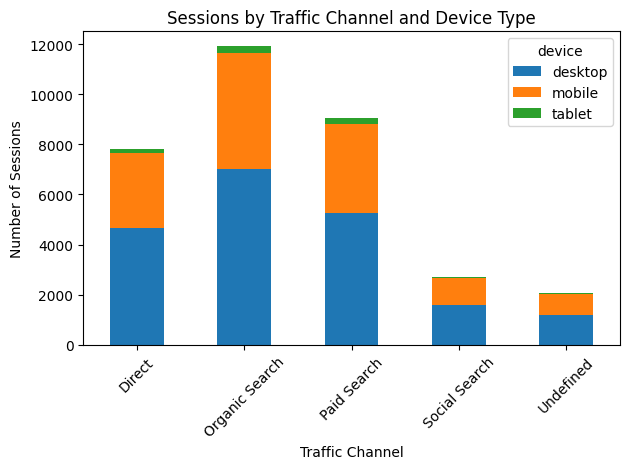

In [ ]:
# Visualize one pivot
plt.figure(figsize=(8,6))
pivot_sessions.plot(kind='bar', stacked=True)
plt.title('Sessions by Traffic Channel and Device Type')
plt.xlabel('Traffic Channel')
plt.xticks(rotation=45)
plt.ylabel('Number of Sessions')
plt.tight_layout()
plt.show()

In [ ]:
daily = df.groupby('order_date').agg(
    sessions=('ga_session_id','nunique'),
    total_sales=('price','sum')
)

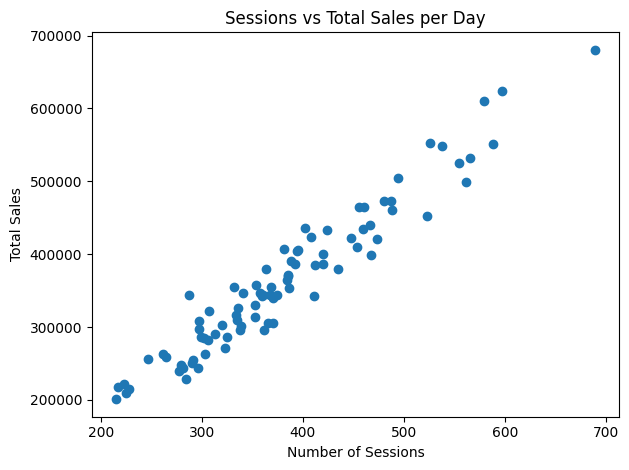

In [ ]:
# Scatter plot
plt.figure()
plt.scatter(daily['sessions'], daily['total_sales'])
plt.title('Sessions vs Total Sales per Day')
plt.xlabel('Number of Sessions')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

In [ ]:
# Correlation
r, p = pearsonr(daily['sessions'], daily['total_sales'])
print(f"Pearson r between sessions and sales: {r:.3f}, p-value: {p:.3g}")

Pearson r between sessions and sales: 0.964, p-value: 2.24e-51


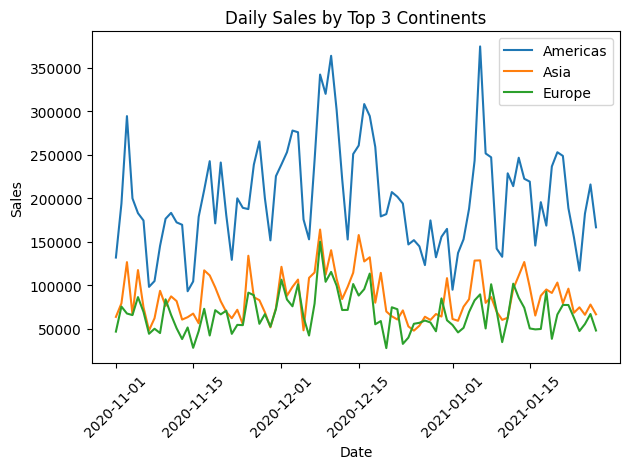

In [ ]:
# Continent-level daily sales correlation for top-3 continents
continent_daily = (
    df.groupby(['order_date','continent'])['price']
    .sum().unstack(fill_value=0)
)

top3_continents = continent_daily.sum().nlargest(3).index
cont3 = continent_daily[top3_continents]

# Plot
plt.figure()
for cont in top3_continents:
    plt.plot(cont3.index, cont3[cont], label=cont)
plt.legend()
plt.title('Daily Sales by Top 3 Continents')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

In [ ]:
# Сompare daily sales distributions across top-3 continents
continent_daily = df.groupby(['order_date','continent'])['price'].sum().unstack(fill_value=0)
top3_continents = continent_daily.sum().nlargest(3).index
groups = [continent_daily[cont] for cont in top3_continents]
f_stat, p_val = f_oneway(*groups)
print(f"ANOVA for daily sales among top 3 continents: F={f_stat:.3f}, p={p_val:.3g}")

ANOVA for daily sales among top 3 continents: F=284.864, p=2.41e-66


In [ ]:
df_cleaned = df[
    (~df['traffic_source'].isin(['(none)', '(data deleted)']))
    & (df['traffic_source'].notna())
].copy()

df_cleaned['traffic_source'] = df_cleaned['traffic_source'].replace('<Other>', 'other')

ANOVA for daily sales among top 5 traffic sources: F=316.810, p=4.04e-99 



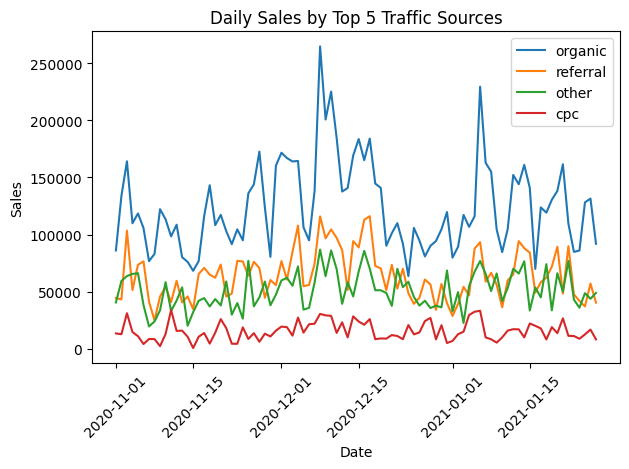

In [ ]:
# Traffic source sales correlation and ANOVA on top-5 sources
traffic_daily = df_cleaned.groupby(['order_date','traffic_source'])['price'].sum().unstack(fill_value=0)
top_sources = traffic_daily.sum().nlargest(5).index
groups_src = [traffic_daily[src] for src in top_sources]
f_src, p_src = f_oneway(*groups_src)
print(f"ANOVA for daily sales among top 5 traffic sources: F={f_src:.3f}, p={p_src:.3g}", "\n")

plt.figure()
for src in top_sources:
    plt.plot(traffic_daily.index, traffic_daily[src], label=src)
plt.legend()
plt.title('Daily Sales by Top 5 Traffic Sources')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

ANOVA for daily sales among top devices: F=516.842, p=1.71e-91 



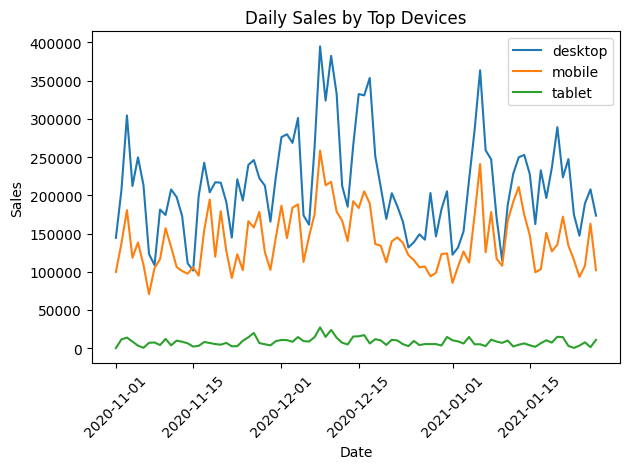

In [ ]:
# Additional ANOVA: sales by device types
device_daily = df.groupby(['order_date','device'])['price'].sum().unstack(fill_value=0)
devices = device_daily.sum().nlargest().index.tolist()
groups_dev = [device_daily[dev] for dev in devices]
f_dev, p_dev = f_oneway(*groups_dev)

print(f"ANOVA for daily sales among top devices: F={f_dev:.3f}, p={p_dev:.3g}", "\n")

plt.figure()
for dev in devices:
    plt.plot(device_daily.index, device_daily[dev], label=dev)
plt.legend()
plt.title('Daily Sales by Top Devices')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

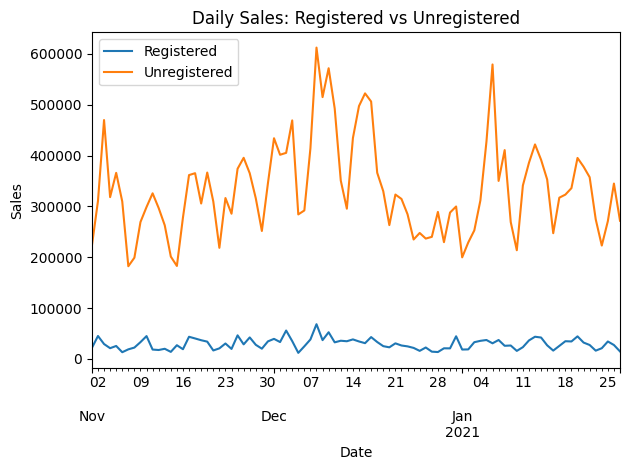

In [ ]:
# 1. Registered vs Unregistered: daily sales distribution
daily_reg = (df[df['account_id'].notna()]
             .groupby('order_date')['price'].sum())
daily_unreg = (df[df['account_id'].isna()]
               .groupby('order_date')['price'].sum())

plt.figure()
daily_reg.plot(label='Registered')
daily_unreg.plot(label='Unregistered')
plt.legend()
plt.title('Daily Sales: Registered vs Unregistered')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

In [ ]:
# Compare distributions via t-test and Mann-Whitney U
t_stat, t_p = ttest_ind(daily_reg, daily_unreg, nan_policy='omit')
w_stat, w_p = mannwhitneyu(daily_reg, daily_unreg)

print(f"T-test: t={t_stat:.3f}, p={t_p:.3g}")
print(f"Mann-Whitney U: U={w_stat:.3f}, p={w_p:.3g}")

T-test: t=-30.552, p=7.76e-72
Mann-Whitney U: U=0.000, p=2.22e-30


In [ ]:
# Sessions by traffic channel: count sessions per channel per day
sessions_daily = (df.groupby(['order_date','traffic_channel'])['ga_session_id']
                  .nunique().unstack(fill_value=0))

# ANOVA across channels
groups_ch = [sessions_daily[col] for col in sessions_daily.columns]
f_ch, p_ch = f_oneway(*groups_ch)
print(f"ANOVA sessions by channel: F={f_ch:.3f}, p={p_ch:.3g}")

ANOVA sessions by channel: F=361.203, p=9.49e-137


In [ ]:
# Proportion of organic sessions in Europe vs America
# Count organic sessions and total sessions
mask_org = df['traffic_source']=='organic'
sess_summary = (df.groupby(['continent','ga_session_id'])['traffic_source']
                .first().reset_index())
cont_counts = sess_summary.groupby('continent')['ga_session_id'].nunique()
org_counts = sess_summary[sess_summary['traffic_source']=='organic']
org_counts = org_counts.groupby('continent')['ga_session_id'].nunique()

# Select Europe and Americas
eu_total = cont_counts.get('Europe', 0)
am_total = cont_counts.get('Americas', 0)
eu_org = org_counts.get('Europe', 0)
am_org = org_counts.get('Americas', 0)
count = np.array([eu_org, am_org])
nobs = np.array([eu_total, am_total])
zstat, pval = proportions_ztest(count, nobs)

print(f"Organic proportion EU vs AM z={zstat:.3f}, p={pval:.3g}")

Organic proportion EU vs AM z=0.562, p=0.574


With p > 0.05, we fail to reject the null hypothesis that the proportion of organic sessions is the same in Europe and the Americas. In other words, there’s no statistically significant difference in organic-traffic share between these two regions.

In [ ]:
# Chi-square: device vs traffic channel session counts
contingency = pd.crosstab(df['device'], df['traffic_channel'])
chi2, chi_p, _, _ = chi2_contingency(contingency)

print(f"Chi-square device vs channel: chi2={chi2:.3f}, p={chi_p:.3g}")

Chi-square device vs channel: chi2=6.386, p=0.604


A p-value above 0.05 means we do not have evidence of an association between device type and traffic channel. Device choice appears independent of channel.

In [ ]:
# Compare price distributions across continents (Kruskal-Wallis)
kw_groups = [df[df['continent']==cont]['price'] for cont in df['continent'].unique()]
from scipy.stats import kruskal
h_stat, kr_p = kruskal(*kw_groups)

print(f"Kruskal-Wallis price by continent: H={h_stat:.3f}, p={kr_p:.3g}")

Kruskal-Wallis price by continent: H=3.280, p=0.657


Again p > 0.05, so the median order values don’t differ significantly across continents. We cannot conclude that one continent tends to pay more (or less) per purchase than another.

In [ ]:
df.to_csv('/content/drive/My Drive/portfolio_project_1.csv', index=False)

###[Tableau](https://public.tableau.com/app/profile/pavlo.korchahin/viz/portfolio_17481933857040/Dashboard1?publish=yes)